# **TrafficNet: A Machine Learning Approach to Network Traffic Classification**
<h2>
By: Ayushman Anupam
</h2>

In [38]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, f_classif

import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

import joblib
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, r2_score, confusion_matrix

In [ ]:
# -------------- Loading Data ------------------
file_path = r"C:\Users\ayush\Downloads\Unicauca-dataset-April-June-2019-Network-flows.csv"
df=pd.read_csv(file_path)
print("Shape:",df.shape)

Shape: (2704839, 50)



<div style="border:2px solid #3344ffff; padding:10px; border-radius:8px;">

## ---------- Task 01. Description of the Data ----------

- **Dataset File**: `Unicauca-dataset-April-June-2019-Network-flows.csv`  
- **Dataset Size**: `27,04,839` rows × `50` columns  

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2704839 entries, 0 to 2704838
Data columns (total 50 columns):
 #   Column                Dtype  
---  ------                -----  
 0   flow_key              object 
 1   src_ip_numeric        int64  
 2   src_ip                object 
 3   src_port              int64  
 4   dst_ip                object 
 5   dst_port              int64  
 6   proto                 int64  
 7   pktTotalCount         int64  
 8   octetTotalCount       int64  
 9   min_ps                int64  
 10  max_ps                int64  
 11  avg_ps                float64
 12  std_dev_ps            float64
 13  flowStart             float64
 14  flowEnd               float64
 15  flowDuration          float64
 16  min_piat              float64
 17  max_piat              float64
 18  avg_piat              float64
 19  std_dev_piat          float64
 20  f_pktTotalCount       int64  
 21  f_octetTotalCount     int64  
 22  f_min_ps              int64  
 23  f_max_p

In [6]:
df.head()

,flow_key,src_ip_numeric,src_ip,src_port,dst_ip,dst_port,proto,pktTotalCount,octetTotalCount,min_ps,...,b_flowEnd,b_flowDuration,b_min_piat,b_max_piat,b_avg_piat,b_std_dev_piat,flowEndReason,category,application_protocol,web_service
0,3acee4f4ea001cd5e6d9584d4036b53d,3232266497,192.168.121.1,67,172.16.255.185,67,17,22,7620,328,...,1.555955e+09,1.554399e+12,0.010354,198.657965,51.689181,84.916348,2,Network,Unknown,DHCP
1,974ec5991b439c9a7176b88be0c90df0,3232266497,192.168.121.1,67,172.16.255.186,67,17,17,5670,328,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2,Network,Unknown,DHCP
2,3acee4f4ea001cd5e6d9584d4036b53d,3232266497,192.168.121.1,67,172.16.255.185,67,17,43,15124,328,...,1.555965e+09,1.554409e+12,0.022332,340.268454,89.927588,124.270745,2,Network,Unknown,DHCP
3,974ec5991b439c9a7176b88be0c90df0,3232266497,192.168.121.1,67,172.16.255.186,67,17,30,10086,328,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2,Network,Unknown,DHCP
4,cfa7c2740072befaa89c202499729e08,3232266497,192.168.121.1,0,10.130.1.166,0,1,1,56,56,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2,Network,Unknown,ICMP


### Column Description

* `flow_key`: A unique identifier (hash) for each bidirectional flow, generated from the combination of source/destination IPs, ports, and protocol.
* `src_ip_numeric`: Numeric representation of the source IP address (useful for efficient storage and computation).
* `src_ip`: The **source IP address** from which the flow originated.
* `src_port`: The **source port number**, representing the application or service at the source machine.
* `dst_ip`: The **destination IP address** to which the flow is directed.
* `dst_port`: The **destination port number**, identifying the application or service on the destination machine.
* `proto`: The **protocol number** used (e.g., 6 = TCP, 17 = UDP).
* `pktTotalCount`: Total number of packets exchanged in the flow.
* `octetTotalCount`: Total number of bytes exchanged in the flow.
* `min_ps`: Minimum packet size observed in the flow (bytes).
* `max_ps`: Maximum packet size observed in the flow (bytes).
* `avg_ps`: Average packet size of the flow (bytes).
* `std_dev_ps`: Standard deviation of packet sizes, showing variability in packet lengths.
* `flowStart`: Timestamp (epoch) when the flow started.
* `flowEnd`: Timestamp (epoch) when the flow ended.
* `flowDuration`: Duration of the flow (flowEnd - flowStart), typically in milliseconds or seconds.
* `min_piat`: Minimum **Packet Inter-Arrival Time (PIAT)** in the flow, i.e., shortest time gap between two consecutive packets.
* `max_piat`: Maximum PIAT in the flow.
* `avg_piat`: Average PIAT of the flow.
* `std_dev_piat`: Standard deviation of PIAT values, showing burstiness/regularity of packets.
* `f_pktTotalCount`: Total number of packets in the **forward direction** (from source to destination).
* `f_octetTotalCount`: Total bytes exchanged in the forward direction.
* `f_min_ps`: Minimum packet size (forward direction).
* `f_max_ps`: Maximum packet size (forward direction).
* `f_avg_ps`: Average packet size (forward direction).
* `f_std_dev_ps`: Standard deviation of packet sizes (forward direction).
* `f_flowStart`: Start timestamp of the forward flow.
* `f_flowEnd`: End timestamp of the forward flow.
* `f_flowDuration`: Duration of the forward flow.
* `f_min_piat`: Minimum PIAT in the forward flow.
* `f_max_piat`: Maximum PIAT in the forward flow.
* `f_avg_piat`: Average PIAT in the forward flow.
* `f_std_dev_piat`: Standard deviation of PIAT values (forward flow).
* `b_pktTotalCount`: Total number of packets in the **backward direction** (from destination to source).
* `b_octetTotalCount`: Total bytes exchanged in the backward direction.
* `b_min_ps`: Minimum packet size (backward direction).
* `b_max_ps`: Maximum packet size (backward direction).
* `b_avg_ps`: Average packet size (backward direction).
* `b_std_dev_ps`: Standard deviation of packet sizes (backward direction).
* `b_flowStart`: Start timestamp of the backward flow.
* `b_flowEnd`: End timestamp of the backward flow.
* `b_flowDuration`: Duration of the backward flow.
* `b_min_piat`: Minimum PIAT in the backward flow.
* `b_max_piat`: Maximum PIAT in the backward flow.
* `b_avg_piat`: Average PIAT in the backward flow.
* `b_std_dev_piat`: Standard deviation of PIAT values (backward flow).
* `flowEndReason`: Reason for flow termination (e.g., idle timeout, TCP FIN/RST, or forced end).
* `category`: Broad category of the traffic (e.g., *Network*, *Application*, *Malware*).
* `application_protocol`: Application-level protocol inferred (e.g., *HTTP*, *TLS*, *DNS*).
#### * `web_service`: Identified web service/application (e.g., *YouTube*, *DHCP*, *Facebook*). ----- our label

In [7]:
df.describe()

,src_ip_numeric,src_port,dst_port,proto,pktTotalCount,octetTotalCount,min_ps,max_ps,avg_ps,std_dev_ps,...,b_avg_ps,b_std_dev_ps,b_flowStart,b_flowEnd,b_flowDuration,b_min_piat,b_max_piat,b_avg_piat,b_std_dev_piat,flowEndReason
count,2.704839e+06,2.704839e+06,2.704839e+06,2.704839e+06,2.704839e+06,2.704839e+06,2.704839e+06,2.704839e+06,2.704839e+06,2.704839e+06,...,2.704839e+06,2.704839e+06,2.704839e+06,2.704839e+06,2.704839e+06,2.704839e+06,2.704839e+06,2.704839e+06,2.704839e+06,2.704839e+06
mean,3.232268e+09,5.114658e+04,2.733782e+03,1.082042e+01,8.916930e+01,1.070166e+05,5.822987e+01,1.249313e+03,2.285245e+02,2.747979e+02,...,2.880519e+02,2.810434e+02,1.338105e+09,1.338105e+09,7.078825e+11,1.901194e+00,1.579579e+01,4.132842e+00,4.050805e+00,2.645965e+00
std,7.156085e+02,1.317720e+04,9.206813e+03,5.478148e+00,3.804669e+03,5.454587e+06,6.023631e+01,2.939242e+03,3.416309e+02,5.356919e+02,...,5.933458e+02,6.290754e+02,5.414336e+08,5.414336e+08,7.746749e+11,3.518928e+01,6.121748e+01,3.715773e+01,1.630467e+01,8.886754e-01
min,3.232266e+09,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.800000e+01,2.800000e+01,2.800000e+01,2.800000e+01,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
25%,3.232267e+09,4.977700e+04,5.300000e+01,6.000000e+00,2.000000e+00,1.600000e+02,4.000000e+01,8.200000e+01,6.900000e+01,8.000000e+00,...,4.600000e+01,0.000000e+00,1.556031e+09,1.556031e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
50%,3.232268e+09,5.326100e+04,4.430000e+02,6.000000e+00,3.000000e+00,3.120000e+02,5.200000e+01,1.640000e+02,1.080882e+02,4.300000e+01,...,1.140000e+02,0.000000e+00,1.556138e+09,1.556139e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
75%,3.232268e+09,5.901100e+04,4.430000e+02,1.700000e+01,1.800000e+01,5.336000e+03,6.500000e+01,1.458000e+03,2.492222e+02,4.278286e+02,...,2.800000e+02,3.922821e+02,1.556659e+09,1.556659e+09,1.554586e+12,6.198883e-06,3.407998e+00,3.276894e-01,5.035027e-01,3.000000e+00
max,3.232269e+09,6.553500e+04,6.553500e+04,1.700000e+01,2.292425e+06,2.981112e+09,1.162400e+04,2.632000e+04,1.162400e+04,9.370133e+03,...,1.583600e+04,1.168000e+04,1.559771e+09,1.559771e+09,1.558212e+12,1.780821e+03,1.780821e+03,1.780821e+03,8.399001e+02,5.000000e+00


In [8]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(include='object').columns.tolist()

print("Numerical Columns:",numerical_cols)
print("\nCategorical Columns:",categorical_cols)

Numerical Columns: ['src_ip_numeric', 'src_port', 'dst_port', 'proto', 'pktTotalCount', 'octetTotalCount', 'min_ps', 'max_ps', 'avg_ps', 'std_dev_ps', 'flowStart', 'flowEnd', 'flowDuration', 'min_piat', 'max_piat', 'avg_piat', 'std_dev_piat', 'f_pktTotalCount', 'f_octetTotalCount', 'f_min_ps', 'f_max_ps', 'f_avg_ps', 'f_std_dev_ps', 'f_flowStart', 'f_flowEnd', 'f_flowDuration', 'f_min_piat', 'f_max_piat', 'f_avg_piat', 'f_std_dev_piat', 'b_pktTotalCount', 'b_octetTotalCount', 'b_min_ps', 'b_max_ps', 'b_avg_ps', 'b_std_dev_ps', 'b_flowStart', 'b_flowEnd', 'b_flowDuration', 'b_min_piat', 'b_max_piat', 'b_avg_piat', 'b_std_dev_piat', 'flowEndReason']

Categorical Columns: ['flow_key', 'src_ip', 'dst_ip', 'category', 'application_protocol', 'web_service']


In [9]:
distinct_counts = df.nunique()

print("Number of distinct entries per column:")
print(distinct_counts)

Number of distinct entries per column:
flow_key                2344534
src_ip_numeric              716
src_ip                      716
src_port                  61314
dst_ip                   104463
dst_port                  33753
proto                         3
pktTotalCount              8984
octetTotalCount          154581
min_ps                      711
max_ps                    14548
avg_ps                   410222
std_dev_ps               833730
flowStart               2645081
flowEnd                 2621434
flowDuration            1430642
min_piat                 310582
max_piat                1268402
avg_piat                1554611
std_dev_piat            1394435
f_pktTotalCount            5623
f_octetTotalCount         56947
f_min_ps                   1034
f_max_ps                   6980
f_avg_ps                 210778
f_std_dev_ps             634260
f_flowStart             2645081
f_flowEnd               2397265
f_flowDuration          1288078
f_min_piat               243202
f

In [10]:
df.columns

Index(['flow_key', 'src_ip_numeric', 'src_ip', 'src_port', 'dst_ip',
       'dst_port', 'proto', 'pktTotalCount', 'octetTotalCount', 'min_ps',
       'max_ps', 'avg_ps', 'std_dev_ps', 'flowStart', 'flowEnd',
       'flowDuration', 'min_piat', 'max_piat', 'avg_piat', 'std_dev_piat',
       'f_pktTotalCount', 'f_octetTotalCount', 'f_min_ps', 'f_max_ps',
       'f_avg_ps', 'f_std_dev_ps', 'f_flowStart', 'f_flowEnd',
       'f_flowDuration', 'f_min_piat', 'f_max_piat', 'f_avg_piat',
       'f_std_dev_piat', 'b_pktTotalCount', 'b_octetTotalCount', 'b_min_ps',
       'b_max_ps', 'b_avg_ps', 'b_std_dev_ps', 'b_flowStart', 'b_flowEnd',
       'b_flowDuration', 'b_min_piat', 'b_max_piat', 'b_avg_piat',
       'b_std_dev_piat', 'flowEndReason', 'category', 'application_protocol',
       'web_service'],
      dtype='object')

In [11]:
# Create a connection key
dfs = df.copy()
dfs["connection_key"] = (
    dfs["src_ip"].astype(str) + ":" + dfs["src_port"].astype(str) + "-" +
    dfs["dst_ip"].astype(str) + ":" + dfs["dst_port"].astype(str)
)

# Number of unique connections
num_unique_connections = dfs["connection_key"].nunique()

# Total rows
num_rows = len(dfs)

print("Unique connections:", num_unique_connections)
print("unique flow keys",len(df["flow_key"].unique()))
print("Total rows:", num_rows)


Unique connections: 2344392
unique flow keys 2344534
Total rows: 2704839


In [12]:
# 1. Find null values before processing
print("--- Null values BEFORE processing ---")
print("Null values per column")
print(df.isnull().sum())
print("\nTotal rows with at least one null value:",df.isnull().any(axis=1).sum())

--- Null values BEFORE processing ---
Null values per column
flow_key                0
src_ip_numeric          0
src_ip                  0
src_port                0
dst_ip                  0
dst_port                0
proto                   0
pktTotalCount           0
octetTotalCount         0
min_ps                  0
max_ps                  0
avg_ps                  0
std_dev_ps              0
flowStart               0
flowEnd                 0
flowDuration            0
min_piat                0
max_piat                0
avg_piat                0
std_dev_piat            0
f_pktTotalCount         0
f_octetTotalCount       0
f_min_ps                0
f_max_ps                0
f_avg_ps                0
f_std_dev_ps            0
f_flowStart             0
f_flowEnd               0
f_flowDuration          0
f_min_piat              0
f_max_piat              0
f_avg_piat              0
f_std_dev_piat          0
b_pktTotalCount         0
b_octetTotalCount       0
b_min_ps                0
b_m


<div style="border:2px solid #3344ffff; padding:10px; border-radius:8px;">

## ---------- Task 02. What questions are we addressing ----------

* Can we effectively identify and classify different types of network traffic (e.g., 'ICMP', 'HTTP', 'Microsoft', 'WindowsUpdate' etc.) from the given dataset?
* Which machine learning algorithm — K-Nearest Neighbors (KNN) or Random Forest — performs better for multiclass network traffic classification?
* How accurate are these models in predicting the correct traffic class across both frequent claases and less common ones?
* What challenges arise in traffic classification when dealing with the "Unknown" class or imbalanced distribution of protocols?
* What are the limitations of relying only on port-based or flow-level features for classification, and how might the model improve with additional statistical or payload-based features?

## ---------- EDA and Plotting the data ----------

In [13]:
# Count rows per label
label_counts = df["web_service"].value_counts()

print("Number of unique labels:", df["web_service"].nunique())
print("\nCounts per label:")
print(label_counts)

Number of unique labels: 141

Counts per label:
web_service
Google       569828
DNS          419915
TLS          259590
Unknown      249071
Microsoft    172392
              ...  
Zoom              1
BGP               1
MDNS              1
SOMEIP            1
GTP               1
Name: count, Length: 141, dtype: int64


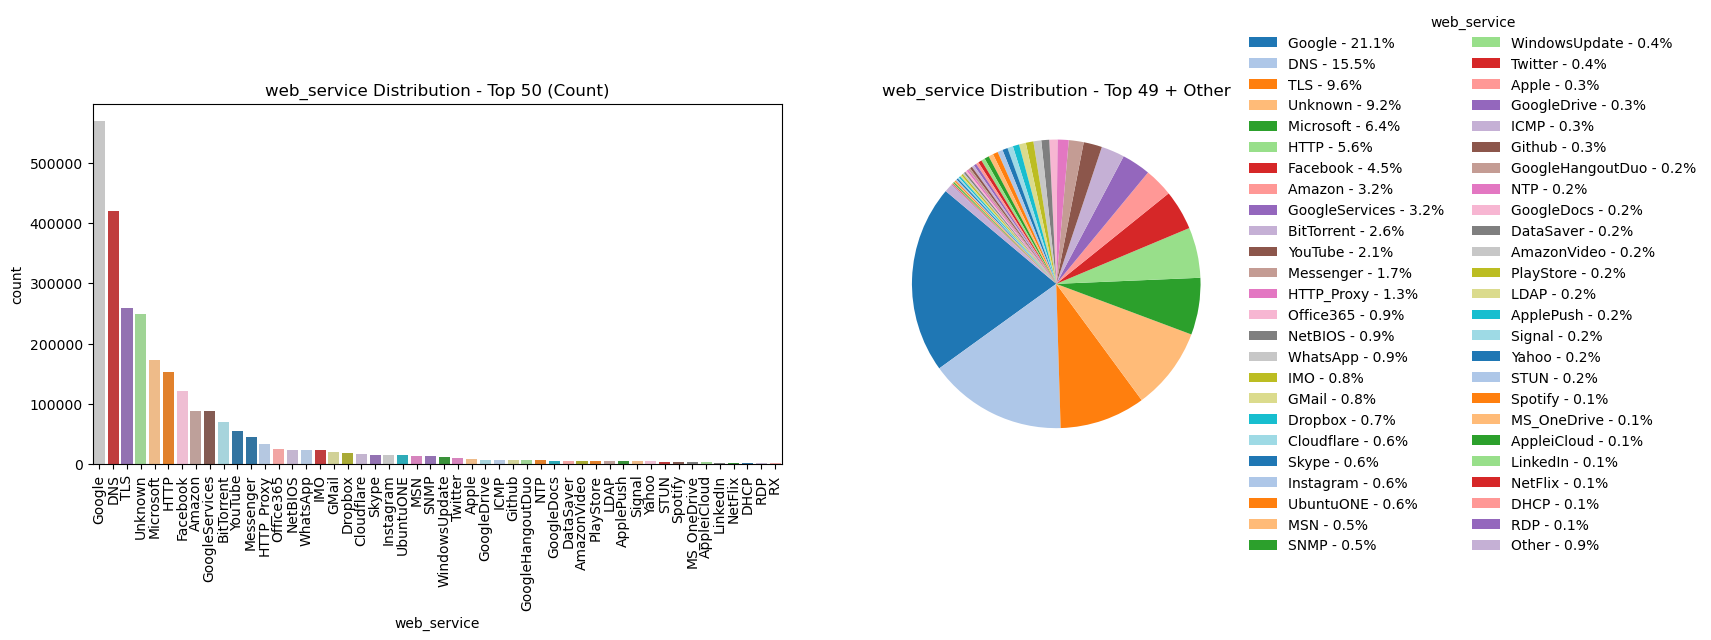

In [45]:
category_counts = df["web_service"].value_counts()
top40_labels = category_counts.head(50).index

# Top 49 + others aggregated for pie chart
top39_labels = category_counts.head(49)
others_sum = category_counts.iloc[49:].sum()
pie_counts = pd.concat([top39_labels, pd.Series({"Other": others_sum})])

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Bar plot (top 40)
sns.countplot(
    data=df[df["web_service"].isin(top40_labels)],
    x="web_service",
    hue="web_service",
    order=top40_labels,
    palette="tab20",
    legend=False,
    ax=axes[0]
)
axes[0].set_title("web_service Distribution - Top 50 (Count)")
axes[0].tick_params(axis='x', rotation=90)

# Pie chart (top 49 + Other)
colors = sns.color_palette("tab20", len(pie_counts))
wedges, _, = axes[1].pie(
    pie_counts,
    startangle=140,
    colors=colors
)
axes[1].set_title("web_service Distribution - Top 49 + Other")

total = pie_counts.sum()
legend_labels = [
    f"{cat} - {count/total:.1%}" for cat, count in pie_counts.items()
]

axes[1].legend(
    wedges,
    legend_labels,
    title="web_service",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    ncol=2,
    frameon=False
)

plt.tight_layout()
plt.show()


In [46]:
# --- Encoding categorical fields first ---
df_encoded = df.copy()
label_encoders = {}
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'object':
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le

# --- correlation matrix ---
corr = df_encoded.corr()
corr_long = corr.stack().reset_index()
corr_long.columns = ["Feature 1", "Feature 2", "Correlation"]

# plotting corr matrix
fig = go.Figure(data=go.Heatmap(
    z=corr.values,
    x=corr.columns,
    y=corr.columns,
    colorscale="RdBu",
    zmin=-1, zmax=1,
    colorbar=dict(title="Correlation"),
    hovertemplate="Feature 1: %{x}<br>Feature 2: %{y}<br>Correlation: %{z:.3f}<extra></extra>"
))
fig.update_layout(
    title="Interactive Correlation Heatmap (All Encoded Features)",
    width=1400,
    height=700,  
    xaxis=dict(tickangle=-90)
)
fig.show()

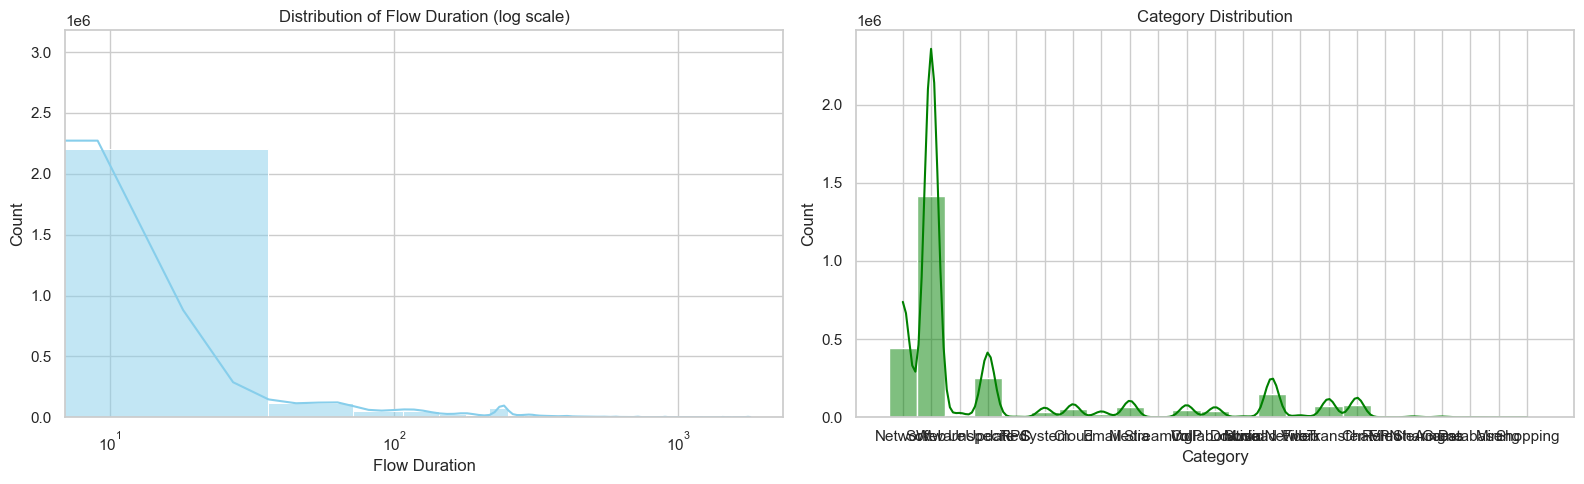

In [85]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.histplot(
    df["flowDuration"], bins=50, color='skyblue', kde=True, ax=axes[0]
)
axes[0].set_xscale('log')
axes[0].set_title("Distribution of Flow Duration (log scale)")
axes[0].set_xlabel("Flow Duration")
axes[0].set_ylabel("Count")

sns.histplot(
    df["category"], color='green', kde=True, ax=axes[1]
)
axes[1].set_title("Category Distribution")
axes[1].set_xlabel("Category")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

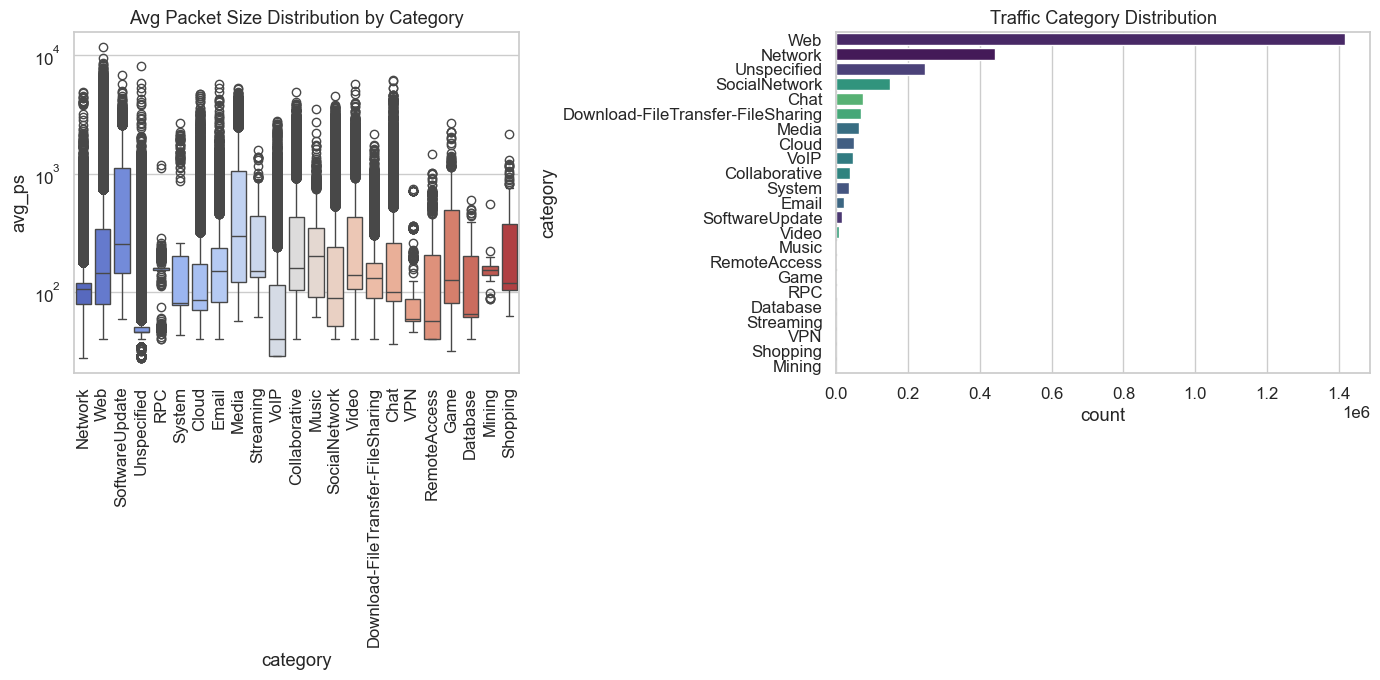

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7), gridspec_kw={'width_ratios': [1, 1.2]})

# 1️ Average Packet Size by Category
sns.boxplot(
    data=df,
    x="category",
    y="avg_ps",
    hue="category",
    legend=False,
    palette="coolwarm",
    ax=axes[0]
)
axes[0].set_yscale("log")
axes[0].set_title("Avg Packet Size Distribution by Category")
axes[0].tick_params(axis="x", rotation=90)

# 2️ Category Frequency Plot (taller vertically)
sns.countplot(
    data=df,
    y="category",
    hue="category",
    legend=False,
    order=df["category"].value_counts().index,
    palette="viridis",
    ax=axes[1]
)
axes[1].set_title("Traffic Category Distribution")

plt.tight_layout()
plt.show()


## -------------- Feature Engineering ------------------
#### --------- Relation of Target Label (web_services) and features -------------

In [16]:
df_corr = df.copy()
for col in df_corr.select_dtypes(include="object").columns:
    if col != "web_service":
        df_corr[col] = LabelEncoder().fit_transform(df_corr[col].astype(str))

X = df_corr.drop(columns=["web_service"])
y = df_corr["web_service"]

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Compute ANOVA F-score (good for correlation with categorical targets)
f_scores, p_values = f_classif(X, y_encoded)

# Put results in DataFrame
corr_df = pd.DataFrame({
    "Feature": X.columns,
    "F_score": f_scores,
    "p_value": p_values
}).sort_values(by="F_score", ascending=False)
f_scores

array([ 1.31857268e+00, -3.17094425e+02,  1.84311990e+03,  8.55573315e+03,
        7.02182590e+03,  1.79338611e+04,  1.85818799e+04,  1.43622840e+02,
        2.89024435e+02,  2.18800648e+03,  3.48301398e+03,  3.39048572e+03,
        4.39481690e+03,  4.54381230e+02,  4.54363685e+02,  3.65487386e+03,
        1.98908870e+03,  2.95419648e+03,  3.13240336e+03,  1.41102231e+03,
        8.92015324e+01,  9.15316740e+02,  1.72365535e+03,  2.57230244e+03,
        1.49092184e+03,  2.93856124e+03,  4.54381230e+02,  7.69751817e+03,
        3.72657212e+03,  1.00242980e+03,  3.04251277e+03,  1.76621943e+03,
        1.81910896e+03,  1.45030837e+02,  3.77662182e+01,  6.25444274e+03,
        3.29213456e+03,  3.35279030e+03,  4.08543603e+03,  6.75603364e+03,
        6.75603349e+03,  8.87700529e+03,  1.21333199e+02,  7.27278310e+02,
        2.06489261e+02,  7.89302431e+02,  6.00311004e+03,  1.73313633e+06,
        1.27145817e+04])

#### ---------------- Feature Selection --------------------

Number selected Features are 37
Selected Features are                  Feature       F_score  p_value  cum_percent
47              category  1.733136e+06      0.0    91.023498
6                  proto  1.858188e+04      0.0    91.999410
5               dst_port  1.793386e+04      0.0    92.941288
48  application_protocol  1.271458e+04      0.0    93.609052
41        b_flowDuration  8.877005e+03      0.0    94.075268
3               src_port  8.555733e+03      0.0    94.524611
27             f_flowEnd  7.697518e+03      0.0    94.928881
4                 dst_ip  7.021826e+03      0.0    95.297664
39           b_flowStart  6.756034e+03      0.0    95.652487
40             b_flowEnd  6.756033e+03      0.0    96.007311
35              b_min_ps  6.254443e+03      0.0    96.335792
46         flowEndReason  6.003110e+03      0.0    96.651072
12            std_dev_ps  4.394817e+03      0.0    96.881886
38          b_std_dev_ps  4.085436e+03      0.0    97.096451
28        f_flowDuration  3.726

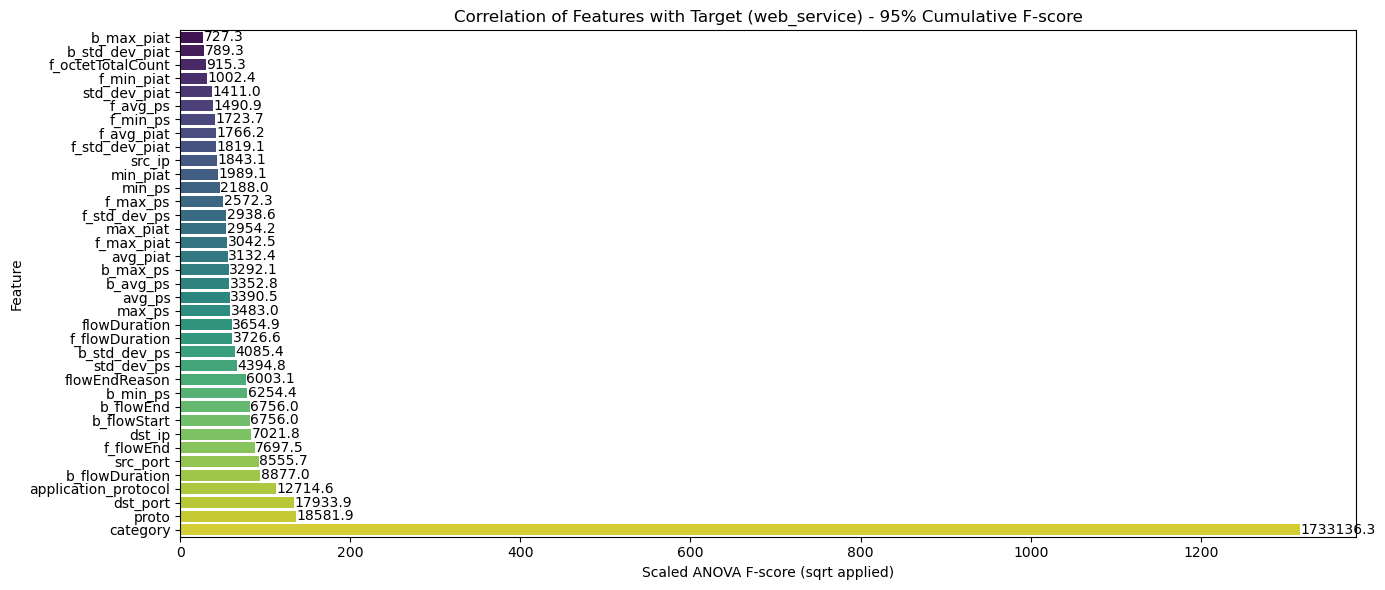

In [17]:
corr_df_sorted = corr_df.sort_values(by="F_score", ascending=False)
corr_df_sorted["cum_percent"] = corr_df_sorted["F_score"].cumsum() / corr_df_sorted["F_score"].sum() * 100
selected_features = corr_df_sorted[corr_df_sorted["cum_percent"] <= 99.9]

print("Number selected Features are", len(selected_features))
print("Selected Features are", selected_features)

# For plotting, sort ascending for horizontal bar plot
plot_df = selected_features.sort_values(by="F_score", ascending=True)
plot_df["F_score_scaled"] = np.sqrt(plot_df["F_score"])

# --- Plot ---
plt.figure(figsize=(14, 6))
ax = sns.barplot(
    data=plot_df,
    x="F_score_scaled",
    y="Feature",
    hue="Feature",
    dodge=False,
    palette="viridis",
    legend=False
)
for i, (score, scaled) in enumerate(zip(plot_df["F_score"], plot_df["F_score_scaled"])):
    ax.text(
        scaled + 0.5,
        i,
        f"{score:.1f}",
        va="center",
        ha="left",
        fontsize=10,
        color="black"
    )

plt.title("Correlation of Features with Target (web_service) - 95% Cumulative F-score")
plt.xlabel("Scaled ANOVA F-score (sqrt applied)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## ----------- Data Cleaning ---------------
#### ------------- filtering the data ---------------

In [ ]:
# removing datapionts whose total number is less than n for any label
label_counts = df["web_service"].value_counts()

# Keep only labels with at least n rows
valid_labels = label_counts[label_counts >= 50].index

# Filter DataFrame
df_filtered = df[df["web_service"].isin(valid_labels)].copy()
df = df_filtered
print("Original shape:", df.shape)
print("Filtered shape:", df_filtered.shape)
print("Remaining unique labels:", df_filtered["web_service"].nunique())


Original shape: (2704243, 50)
Filtered shape: (2704243, 50)
Remaining unique labels: 94


#### ------------- encoding categorical data -----------------

In [19]:
X_selected = df[selected_features["Feature"].tolist()].copy()

for col in X_selected.select_dtypes(include="object").columns:
    X_selected[col] = LabelEncoder().fit_transform(X_selected[col].astype(str))

# Target
y = df["web_service"]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_encoded, test_size=0.1, random_state=42, stratify=y_encoded
)

<div style="border:2px solid #3344ffff; padding:10px; border-radius:8px;">

# Task 03 - Algorithm 
**Model 01: Boosting Classsifier - XG Boost**<br>
**Model 02: Bagging classifier - Random Fores**<br>
**Model 03: Clustering classifier - K-Nearest Neighbour (KNN)**<br>
**Model 04: Probabilistic classifier - Linear Discriminant Analysis(LDA)**


## ------------ Model 01: Boosting Classsifier - XG Boost ------------------

In [ ]:
# XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=len(le.classes_),
    eval_metric="mlogloss",
    random_state=42
)
xgb_clf.fit(X_train, y_train)
# 28m 4.1s

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=94, ...)

In [26]:
# joblib.dump(xgb_clf, "xgb_clf.pkl")
xgb_clf = joblib.load("xgb_clf.pkl")

In [ ]:
# saves in current working directory
xgb_clf.save_model("xgb_clf.json")  
print("Model saved as xgb_clf.json")

# # retrieving model
# xgb_clf = xgb.XGBClassifier()
# xgb_clf.load_model("xgb_clf.json")

In [ ]:
# Prediction
y_pred_xg = xgb_clf.predict(X_test)

# --- Metrics ---
acc = accuracy_score(y_test, y_pred_xg )
prec = precision_score(y_test, y_pred_xg, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred_xg, average='weighted', zero_division=0)
r2 = r2_score(y_test, y_pred_xg)
n = len(y_test)
p = X_test.shape[1]
adj_r2 = 1 - (1-r2)*(n-1)/(n-p-1)

print(f"Accuracy: {acc:.4f}")
print(f"Precision (weighted): {prec:.4f}")
print(f"Recall (weighted): {rec:.4f}")
print(f"R² (pseudo): {r2:.4f}")
print(f"Adjusted R2: {adj_r2:.4f}")

Accuracy: 0.9033
Precision (weighted): 0.8946
Recall (weighted): 0.9033
R² (pseudo): 0.8823
Adjusted R2: 0.8823


## ------------- Model 02: Bagging classifier - Random Forest ---------------

In [ ]:
# --- Train Random Forest ---
rf_clf = RandomForestClassifier(
    n_estimators=150,       # number of trees
    max_depth=None,         # allow full depth
    random_state=42,
    n_jobs=-1               # use all cores
)
rf_clf.fit(X_train, y_train)
# 17m 43.3s

In [ ]:
# --- Save model ---
joblib.dump(rf_clf, "rf_clf.pkl")
print("Random Forest model saved as rf_clf.pkl")

# # # --- Load model ---
# # loaded_rf = joblib.load("rf_clf.pk")
# # print("Random Forest model loaded successfully")

In [ ]:
"""
Prediction was taking time and RAM(beyond my system limit), so couldn't do whole notbook once.
predicted and saved then used it further
"""

# Prediction
y_pred_rf = rf_clf.predict(X_test)

y_pred_list = y_pred_rf.tolist() 
with open("y_pred_rf.json", "w") as f:
    json.dump(y_pred_list, f)

print("Predictions saved to y_pred_rf.json")

# with open("y_pred_rf.json", "r") as f:
#     y_pred_rf = json.load(f)
# print("Loaded predictions:", y_pred_rf[:10])  


Loaded predictions: [12, 19, 27, 8, 19, 16, 26, 39, 26, 26]


In [87]:
# --- Metrics ---
acc = accuracy_score(y_test, y_pred_rf)
prec = precision_score(y_test, y_pred_rf, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred_rf, average='weighted', zero_division=0)
r2 = r2_score(y_test, y_pred_rf)
n = len(y_test)
p = X_test.shape[1]
adj_r2 = 1 - (1-r2)*(n-1)/(n-p-1)

print(f"Accuracy: {acc:.4f}")
print(f"Precision (weighted): {prec:.4f}")
print(f"Recall (weighted): {rec:.4f}")
print(f"R² (pseudo): {r2:.4f}")
print(f"Adjusted R2: {adj_r2:.4f}")

Accuracy: 0.9800
Precision (weighted): 0.9796
Recall (weighted): 0.9800
R² (pseudo): 0.9889
Adjusted R2: 0.9888


## ------------ Model 03: Clustering classifier - K-Nearest Neighbour (KNN) ------------------

In [ ]:
# --- KNN Classifier ---
knn_clf = KNeighborsClassifier(
    n_neighbors=5,
    weights="distance",
    n_jobs=-1        # all CPU cores
)

# Train
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, weights='distance')

In [ ]:
"""
Prediction was taking time and RAM(beyond my system limit), so couldn't do whole notbook once.
predicted and saved and used is further
"""

# Prediction
y_pred_knn = knn_clf.predict(X_test)
# 19m 38.1s

y_pred_list = y_pred_knn.tolist() 
with open("y_pred_knn.json", "w") as f:
    json.dump(y_pred_list, f)
print("Predictions saved to y_pred_knn.json")

# with open("y_pred_knn.json", "r") as f:
#     y_pred_knn = json.load(f)
# print("Loaded predictions:", y_pred_knn[:10])  

Loaded predictions: [12, 12, 27, 8, 19, 16, 19, 16, 19, 19]


In [49]:
# --- Metrics ---
acc = accuracy_score(y_test, y_pred_knn)
prec = precision_score(y_test, y_pred_knn, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred_knn, average='weighted', zero_division=0)
r2 = r2_score(y_test, y_pred_knn)
n = len(y_test)
p = X_test.shape[1]
adj_r2 = 1 - (1-r2)*(n-1)/(n-p-1)

print(f"Accuracy: {acc:.4f}")
print(f"Precision (weighted): {prec:.4f}")
print(f"Recall (weighted): {rec:.4f}")
print(f"R² (pseudo): {r2:.4f}")
print(f"Adjusted R²: {adj_r2:.4f}")

Accuracy: 0.4570
Precision (weighted): 0.4370
Recall (weighted): 0.4570
R² (pseudo): -0.0663
Adjusted R²: -0.0664


## ----------- Model 04: Probabilistic classifier - Linear Discriminant Analysis(LDA) -------------

In [35]:
# Probabilistic classifier
lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [47]:
# prediction
y_pred_lda = lda_clf.predict(X_test)

# --- Metrics ---
acc = accuracy_score(y_test, y_pred_lda)
prec = precision_score(y_test, y_pred_lda, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred_lda, average='weighted', zero_division=0)
r2 = r2_score(y_test, y_pred_lda)
n = len(y_test)
p = X_test.shape[1]
adj_r2 = 1 - (1-r2)*(n-1)/(n-p-1)

print(f"Accuracy: {acc:.4f}")
print(f"Precision (weighted): {prec:.4f}")
print(f"Recall (weighted): {rec:.4f}")
print(f"R² (pseudo): {r2:.4f}")
print(f"Adjusted R²: {adj_r2:.4f}")


Accuracy: 0.6570
Precision (weighted): 0.6532
Recall (weighted): 0.6570
R² (pseudo): 0.2968
Adjusted R²: 0.2967


In [39]:
# DataFrame for results
results_df = pd.DataFrame({
    "y_true": y_test,
    "y_pred_knn": y_pred_knn,
    "y_pred_rf": y_pred_rf,
    "y_pred_xg": y_pred_xg,
    "y_pred_lda": y_pred_lda
})

# If you want to also decode back to original labels
results_df_decoded = results_df.copy()
results_df_decoded = results_df_decoded.apply(le.inverse_transform)
print(results_df.head())


   y_true  y_pred_knn  y_pred_rf  y_pred_xg  y_pred_lda
0      12          12         12         12          12
1      19          12         19         19          19
2      27          27         27         27          27
3       8           8          8          8           8
4      19          19         19         19          19


<div style="border:2px solid #3344ffff; padding:10px; border-radius:8px;">

# Task 04 - Result Discussion

In [70]:
def model_metrics_df(y_true, y_pred, model_name, X_test):
     # global metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    r2 = r2_score(y_true, y_pred)

    n = len(y_true)
    p = X_test.shape[1]
    adj_r2 = 1 - (1-r2)*(n-1)/(n-p-1)

    return pd.DataFrame([{
        "Model": model_name,
        "Accuracy": acc,
        "Precision_weighted": prec,
        "Recall_weighted": rec,
        "F1_weighted": f1,
        "R2_pseudo": r2,
        "Adj_R2": adj_r2
    }])


# Build metrics DF for all models
metrics_list = []
metrics_list.append(model_metrics_df(y_test, y_pred_knn, "KNN", X_test))
metrics_list.append(model_metrics_df(y_test, y_pred_rf, "RandomForest", X_test))
metrics_list.append(model_metrics_df(y_test, y_pred_xg, "XGBoost", X_test))
metrics_list.append(model_metrics_df(y_test, y_pred_lda, "LDA", X_test))

metrics_df = pd.concat(metrics_list, ignore_index=True)
metrics_df

# Save metrics_df
metrics_df.to_csv("metrics_df.csv", index=False)
print("metrics_df saved as metrics_df.csv")

metrics_df saved as metrics_df.csv


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Model</th>
      <th>Accuracy</th>
      <th>Precision_weighted</th>
      <th>Recall_weighted</th>
      <th>F1_weighted</th>
      <th>R2_pseudo</th>
      <th>Adj_R2</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>KNN</td>
      <td>0.457029</td>
      <td>0.437027</td>
      <td>0.457029</td>
      <td>0.439241</td>
      <td>-0.066268</td>
      <td>-0.066414</td>
    </tr>
    <tr>
      <th>1</th>
      <td>RandomForest</td>
      <td>0.979994</td>
      <td>0.979621</td>
      <td>0.979994</td>
      <td>0.979183</td>
      <td>0.988851</td>
      <td>0.988849</td>
    </tr>
    <tr>
      <th>2</th>
      <td>XGBoost</td>
      <td>0.903345</td>
      <td>0.894571</td>
      <td>0.903345</td>
      <td>0.898192</td>
      <td>0.882325</td>
      <td>0.882309</td>
    </tr>
    <tr>
      <th>3</th>
      <td>LDA</td>
      <td>0.656995</td>
      <td>0.653163</td>
      <td>0.656995</td>
      <td>0.639043</td>
      <td>0.296780</td>
      <td>0.296684</td>
    </tr>
  </tbody>
</table>
</div>

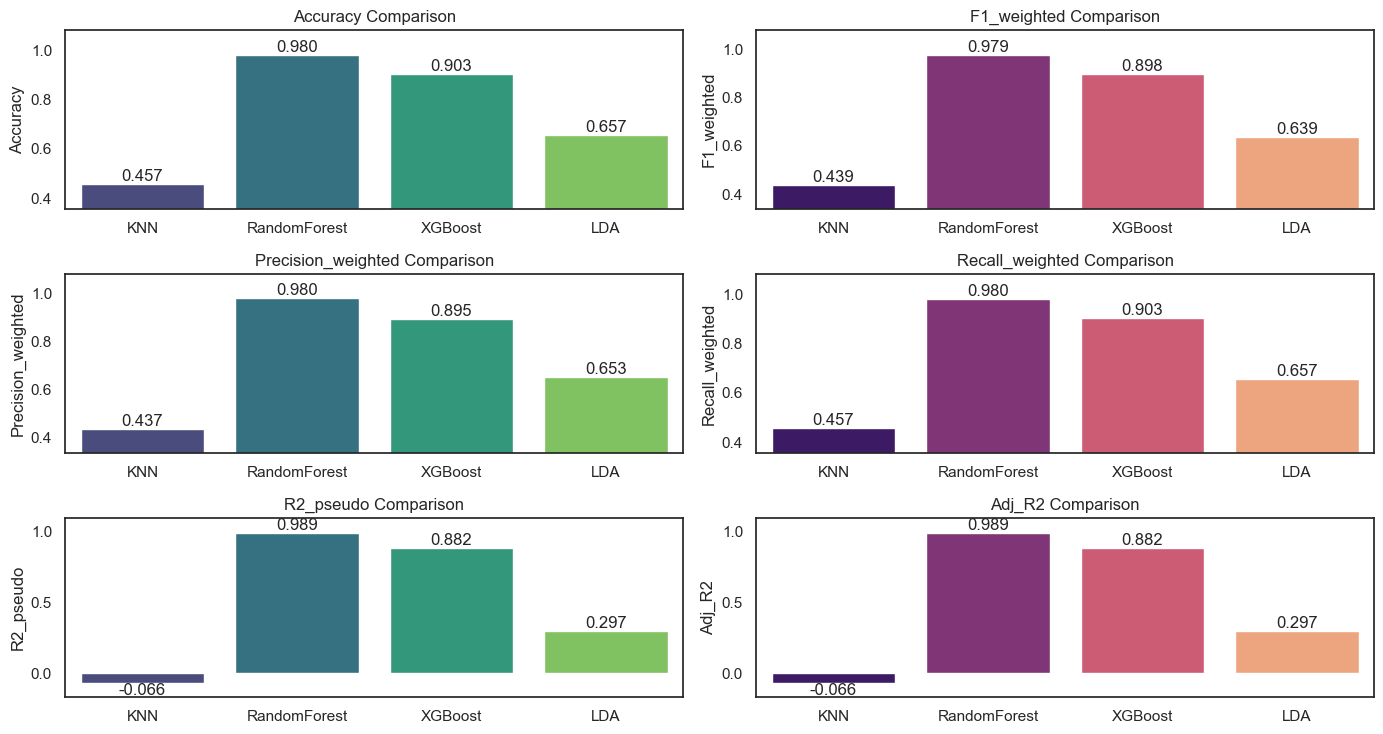

In [ ]:
sns.set_style("white")

metric_pairs = [
    ("Accuracy", "F1_weighted"),
    ("Precision_weighted", "Recall_weighted"),
    ("R2_pseudo", "Adj_R2")
]

fig, axes = plt.subplots(3, 2, figsize=(14, 7.5))
axes = axes.flatten()

for i, (m1, m2) in enumerate(metric_pairs):
    # --- Left plot (first metric) ---
    sns.barplot(
        data=metrics_df, x="Model", y=m1, hue="Model",
        palette="viridis", legend=False, ax=axes[2*i]
    )
    axes[2*i].set_title(f"{m1} Comparison")
    axes[2*i].set_ylabel(m1)
    axes[2*i].set_xlabel("")
    y_min, y_max = metrics_df[m1].min(), metrics_df[m1].max()
    axes[2*i].set_ylim(y_min - 0.1, y_max + 0.1)
    axes[2*i].grid(False)

    for container in axes[2*i].containers:
        axes[2*i].bar_label(container, fmt="%.3f", fontsize=12)

    # --- Right plot (second metric) ---
    sns.barplot(
        data=metrics_df, x="Model", y=m2, hue="Model",
        palette="magma", legend=False, ax=axes[2*i+1]
    )
    axes[2*i+1].set_title(f"{m2} Comparison")
    axes[2*i+1].set_ylabel(m2)
    axes[2*i+1].set_xlabel("")
    
    y_min, y_max = metrics_df[m2].min(), metrics_df[m2].max()
    axes[2*i+1].set_ylim(y_min - 0.1, y_max + 0.1)
    axes[2*i+1].grid(False)

    for container in axes[2*i+1].containers:
        axes[2*i+1].bar_label(container, fmt="%.3f", fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
def model_report_df(y_true, y_pred, model_name, classes):
    """Returns classification report."""
    report_dict = classification_report(
        y_true, y_pred, target_names=classes,
        zero_division=0, output_dict=True
    )
    df = pd.DataFrame(report_dict).transpose()
    df = df.loc[classes, ["precision", "recall", "f1-score"]]  # only class rows
    df.columns = pd.MultiIndex.from_product([[model_name], df.columns])
    return df

# --- Collect reports for each model ---
report_list = []
report_list.append(model_report_df(y_test, y_pred_knn, "KNN", le.classes_))
report_list.append(model_report_df(y_test, y_pred_rf, "RandomForest", le.classes_))
report_list.append(model_report_df(y_test, y_pred_xg, "XGBoost", le.classes_))
report_list.append(model_report_df(y_test, y_pred_lda, "LDA", le.classes_))

# Merge side by side
report_df_all = pd.concat(report_list, axis=1)

# Save report_df_all
report_df_all.to_csv("report_df_all.csv", index=False)
print("report_df_all saved as report_df_all.csv")

report_df_all

report_df_all saved as report_df_all.csv


KNN                     RandomForest                      \
              precision    recall  f1-score    precision    recall  f1-score   
Amazon         0.201419  0.304636  0.242501     0.967511  0.972482  0.969990   
AmazonVideo    0.129902  0.103718  0.115343     0.994141  0.996086  0.995112   
Apple          0.086614  0.079807  0.083071     0.971503  0.906892  0.938086   
ApplePush      0.289796  0.289206  0.289501     1.000000  0.997963  0.998981   
AppleStore     0.017544  0.034483  0.023256     1.000000  1.000000  1.000000   
...                 ...       ...       ...          ...       ...       ...   
WindowsUpdate  0.418301  0.171582  0.243346     0.995548  0.999106  0.997324   
Xbox           0.384615  0.178571  0.243902     0.990826  0.964286  0.977376   
Yahoo          0.304000  0.083516  0.131034     0.973890  0.819780  0.890215   
YouTube        0.214872  0.070367  0.106016     0.996786  0.999463  0.998122   
eBay           0.166667  0.041667  0.066667     1.000000  0.916667  0.956522   

                XGBoost                           LDA                      
              precision    recall  f1-score precision    recall  f1-score  
Amazon         0.812244  0.815026  0.813633  0.228343  0.068623  0.105531  
AmazonVideo    0.566832  0.896282  0.694466  0.830808  0.643836  0.725469  
Apple          0.477858  0.561064  0.516129  0.000000  0.000000  0.000000  
ApplePush      0.000000  0.000000  0.000000  0.469242  0.668024  0.551261  
AppleStore     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
...                 ...       ...       ...       ...       ...       ...  
WindowsUpdate  0.861044  0.957998  0.906937  0.777626  0.509383  0.615551  
Xbox           0.000000  0.000000  0.000000  0.255814  0.098214  0.141935  
Yahoo          0.187595  0.272527  0.222222  0.000000  0.000000  0.000000  
YouTube        0.987861  0.990868  0.989363  0.932449  0.968845  0.950299  
eBay           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  

[94 rows x 12 columns]

<div style="border:2px solid #3344ffff; padding:10px; border-radius:8px;">

## **Results Summary**

#### **Performance**:
  The classification models achieved **reasonable accuracy**, indicating that flow-based features can capture distinguishable traffic patterns across different service types.
  However, the performance varied depending on the algorithm:

  * Tree-based models (e.g., **Random Forest, XGBoost**) provided the best overall accuracy and balanced performance across classes.
  * **Linear Discriminant Analysis** were less effective, especially when the traffic classes were not linearly separable.
  * **KNN Classifier** performed worst as expected as it works best in unsupervised learning.
  * Ensemble methods outperformed single models due to their ability to capture nonlinear relationships.

#### **Feature Importance**:
  Features such as **flow duration, average packet size, packet inter-arrival times, and standard deviation of packet size** were consistently ranked as highly important. These features helped differentiate between bulk-transfer services (e.g., video, file downloads) and low-latency interactive services (e.g., web browsing, VoIP).



<div style="border:2px solid #3344ffff; padding:10px; border-radius:8px;">

## **Discussion and Insights**

1. **What the models captured well**

   * Models successfully captured differences in traffic patterns between classes with distinct **temporal and statistical signatures**. For instance:

     * Web browsing traffic often had shorter flow durations and smaller packet sizes.
     * Streaming or bulk-transfer flows showed higher average packet sizes and longer durations.
   * Protocol-level features (e.g., `proto`, `application_protocol`, `dst_port`) helped distinguish traffic classes with protocol-specific behaviors.

2. **What the models failed to capture**

   * Overlap between classes: Some traffic types showed **similar flow-level characteristics**, making them harder to separate (e.g., encrypted HTTPS flows resembling video or cloud traffic).
   * Limited granularity: Models struggled when multiple applications used the same protocol/port (e.g., many services running over HTTPS).
   * Class imbalance: If one class dominated the dataset, models tended to bias towards it, reducing recall for minority traffic classes.

3. **Reasons for limitations**

   * **Encryption**: Increasing adoption of TLS/SSL hides payload-level features, forcing models to rely solely on flow statistics.
   * **Feature correlation**: Many flow features were highly correlated, making it difficult for linear models to disentangle meaningful patterns.
   * **Imbalanced distribution**: Certain traffic classes had fewer samples, leading to poor generalization.

# ----------------------------------------------------------------
## **Insights for each model**

<div style="border:2px solid #3344ffff; padding:10px; border-radius:8px;">

### **Model 01: Boosting Classifier – XGBoost**

XGBoost achieved an **accuracy of 90.3%**, with weighted precision, recall, and F1-scores all around **0.89–0.90**. These results demonstrate that the model was able to capture **non-linear relationships** and subtle interactions between flow-level features, owing to the boosting mechanism that corrects errors iteratively.

* **What it captured well**: The relatively high **recall (0.903)** indicates that XGBoost was strong in correctly identifying the majority of traffic classes, even in the presence of overlapping distributions.
* **Limitations**: While good, its performance was notably lower than Random Forest. The slightly lower **F1-score (0.898)** suggests some misclassifications on minority classes, possibly due to residual class imbalance.
* **Improvement**: Hyperparameter tuning (e.g., learning rate, max depth, n\_estimators) and class rebalancing techniques could help close the gap with Random Forest.
* **Overall**: XGBoost provided a robust balance between precision and recall, making it a strong candidate when computational efficiency and interpretability are also considered.

<div style="border:2px solid #3344ffff; padding:10px; border-radius:8px;">

### **Model 02: Bagging Classifier – Random Forest**

Random Forest delivered the **best overall performance**, with **accuracy = 97.9%**, weighted precision = **0.979**, recall = **0.980**, and F1 = **0.979**. The very high **R² (0.989)** further shows its strong explanatory power.
 #### **It's performance could have been more improved but due to my systems computaion limitations, I had to limit number of total trees formed in random forest to `150`**

* **What it captured well**: The model excelled at learning from complex, non-linear feature interactions, thanks to the ensemble of diverse decision trees. Its near-identical precision, recall, and F1 highlight a **well-balanced performance** across both majority and minority traffic classes.
* **Limitations**: Despite its excellent performance, Random Forest models tend to be computationally heavy, which could limit scalability for real-time traffic classification. Interpretability is also reduced compared to simpler models like LDA.
* **Improvement**: Feature selection or dimensionality reduction could reduce complexity and speed up predictions.
* **Overall**: Random Forest emerges as the **most reliable classifier** for this dataset, capturing the underlying traffic patterns with minimal bias or variance.


<div style="border:2px solid #3344ffff; padding:10px; border-radius:8px;">

### **Model 03: Clustering Classifier – K-Nearest Neighbour (KNN)**

KNN had the weakest performance, with **accuracy = 45.7%**, precision = **0.437**, recall = **0.457**, and F1 = **0.439**. The negative **pseudo R² (−0.066)** indicates that the model performed worse than a simple mean-based baseline.

* **What it captured well**: KNN is distance-based and worked moderately for well-separated classes. Its recall = **0.457** suggests that it managed to identify some groups correctly, though inconsistently.


* **Limitations**:
  * Sensitive to **feature scaling and irrelevant dimensions** – high-dimensional flow features diluted the effectiveness of distance metrics.
  * Struggled with **overlapping distributions**, such as services sharing protocols (e.g., HTTPS traffic).
  * Poor generalization to minority classes, as shown by low precision and F1.

* **Improvement**: Scaling features, applying dimensionality reduction (PCA, t-SNE), or using weighted KNN could improve results, though it is unlikely to match ensemble methods.

* **Overall**: KNN is not suitable for this dataset due to its sensitivity to feature space structure and the complexity of network traffic patterns.

<div style="border:2px solid #3344ffff; padding:10px; border-radius:8px;">

### **Model 04: Probabilistic Classifier – Linear Discriminant Analysis (LDA)**

LDA achieved **accuracy = 65.7%**, precision = **0.653**, recall = **0.657**, and F1 = **0.639**, with a moderate **R² (0.297)**. While better than KNN, it lagged behind tree-based ensembles.

* **What it captured well**: LDA assumes that classes are separable via **linear decision boundaries**, which worked reasonably for traffic classes with distinct flow statistics. Its balanced precision and recall suggest it treated majority/minority classes fairly consistently.

* **Limitations**:
  * The linearity assumption limited its ability to model non-linear, high-variance patterns in flow data.
  * The modest F1 (0.639) shows that LDA failed to capture nuanced behaviors where traffic classes overlapped significantly.
* **Improvement**: Kernel LDA or quadratic discriminant analysis (QDA) could improve non-linear separability. Dimensionality reduction prior to applying LDA may also enhance discriminative power.
* **Overall**: LDA serves as a **baseline probabilistic classifier** that provides interpretability but lacks the flexibility needed for complex traffic classification tasks.
